<span style="color:red">
To get this notebook running, please install: <br> 
1. sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config <br>
2. pip install pygraphviz
</span>

In [1]:
import sys
import os

repo_path = os.path.sep.join(os.getcwd().split(os.path.sep)[:-3])
sys.path.append(repo_path)
# resolves problem for Niklas os.chdir(repo_path)
#%cd /home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24/
%cd ../../..


/home/loebbert/projects/deepclustering/LMU_Master_Practical_SoSe24


In [2]:

import pandas as pd
from clustpy.deep.autoencoders import FeedforwardAutoencoder
from practical.DeepClustering.DeepECT.evaluation_pipeline import DatasetType, evaluate_multiple_seeds, calculate_flat_mean_for_multiple_seeds, calculate_hierarchical_mean_for_multiple_seeds
import torch
import matplotlib.pyplot as plt
from clustpy.data import load_fmnist, load_mnist, load_usps
import random
import numpy as np
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_custom_dataloader_augmentations, DatasetType, AutoencoderType
from practical.DeepClustering.DeepECT.deepect import DeepECT
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
from sklearn.utils import Bunch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


[WARNING] Could not import cv2 in clustpy.data.real_video_data. Please install cv2 by 'pip install opencv-python' if necessary


# Preliminary setting

## Visualizing pretrained autoencoders

In [16]:
def visualize_peformance_AE(param_path_autoencoder: str, autoencoder_class: torch.nn.Module, dataset: Bunch, image_size: tuple, number_samples: int, seed: int = None):

    if seed is not None and type(seed) == int:
        random.seed(seed)

    autoencoder = pretraining(autoencoder_class, param_path_autoencoder, data, seed, 10)
    samples = data["data"]
    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(
        sorted(random.sample(range(samples.shape[0]), number_samples))
    ):
        img = samples[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        img_rec = autoencoder.decode(autoencoder.encode(torch.from_numpy(img))).detach().numpy()
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_rec.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'reconstructed')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()

    embeddings = autoencoder.encode(torch.from_numpy(data)).detach().clone().numpy()

    # PCA of embedded space
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of embedded space')
    plt.colorbar(label='Digit')
    plt.show()
    
    # TSNE from embedded space
    plt.figure()
    projected_data = TSNE(n_components=2, perplexity=40, n_iter=500).fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of embedded space')
    plt.colorbar(label='Digit')
    plt.show()

##### MNIST

Autoencoder parameters loaded from file.
Autoencoder parameters loaded from file.


(None, None)

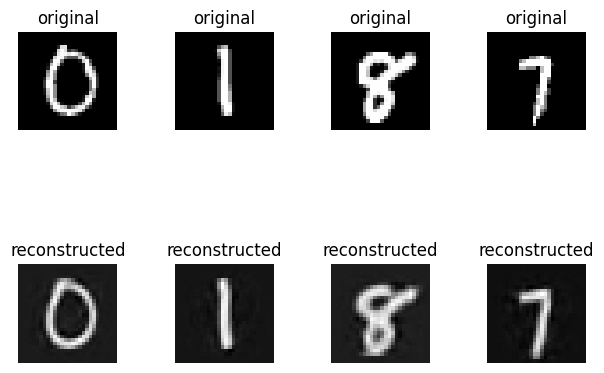

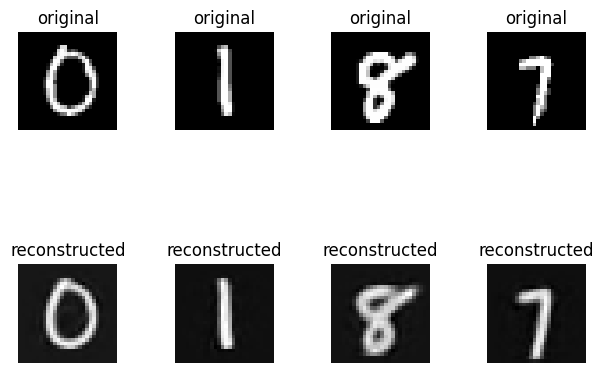

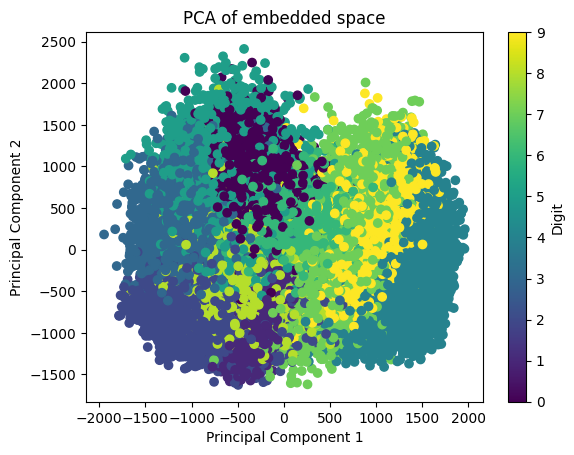

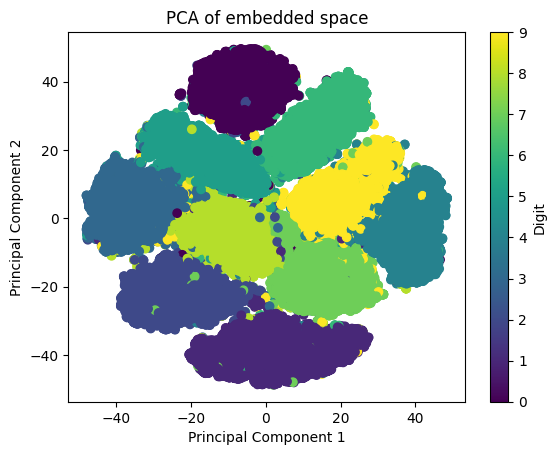

In [18]:
dataset = load_mnist()
dataset["data"] = dataset["data"] / 255.0
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_autoencoder_10_pretrained_21.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_stacked_ae_10_pretrained_21.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

##### USPS

Autoencoder parameters loaded from file.
Autoencoder parameters loaded from file.


(None, None)

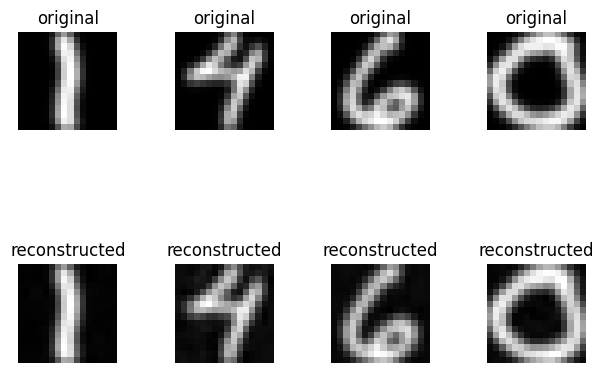

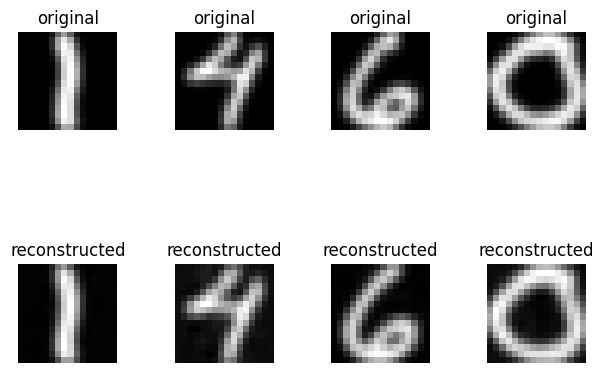

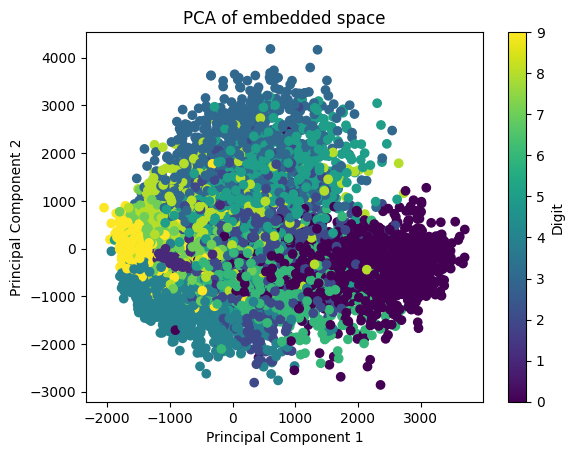

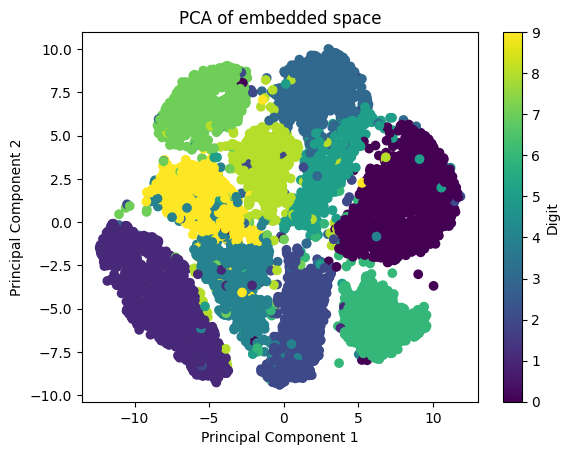

In [10]:
dataset = load_usps()
dataset["data"] = dataset["data"] / 255.0
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_autoencoder_10_pretrained_42.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (16, 16),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_stacked_ae_10_pretrained_42.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (16, 16),
    4,
    seed=21,
)

##### FMNIST

Autoencoder parameters loaded from file.
Autoencoder parameters loaded from file.


(None, None)

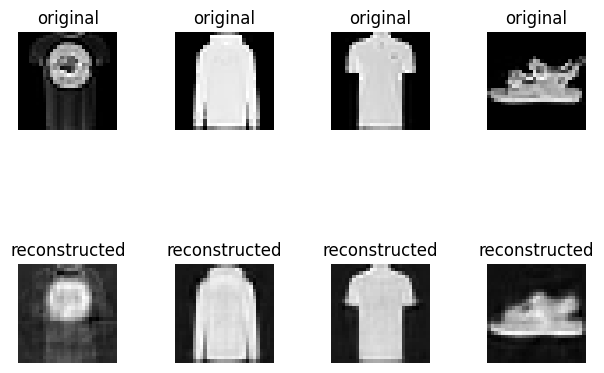

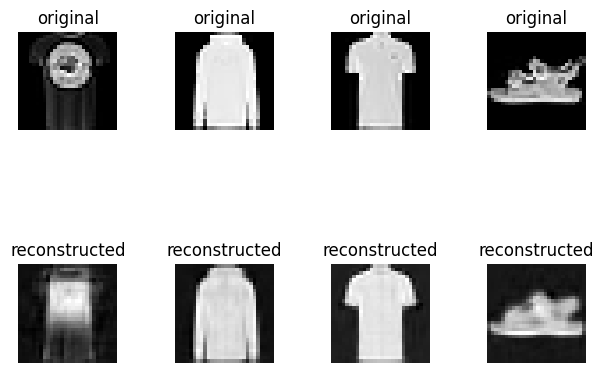

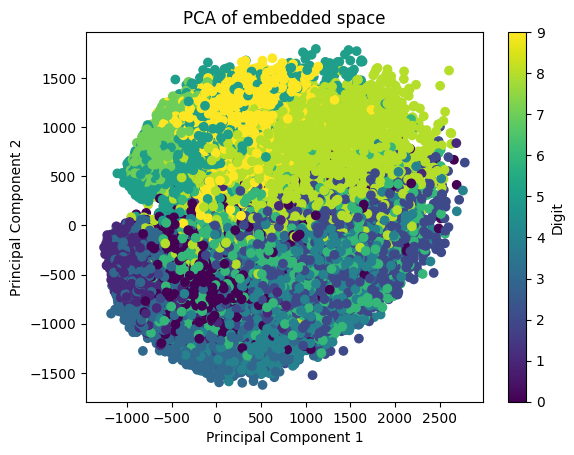

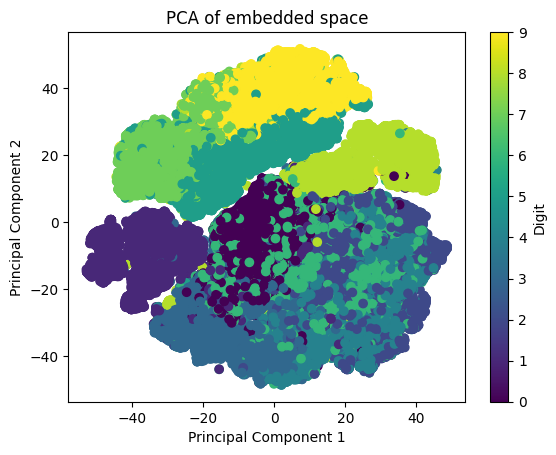

In [17]:
dataset = load_fmnist()
dataset["data"] = dataset["data"] / 255.0
data = dataset["data"] 
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_10_pretrained_42.pth",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_stacked_ae_10_pretrained_42.pth",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

## Visualization of augmented data

In [7]:
def show_augmented_data(data: np.ndarray, dataset_type: DatasetType, image_size: tuple, number_samples: int):

    (trainloader, _) = get_custom_dataloader_augmentations(data, dataset_type)
    idx, M, M_aug = next(iter(trainloader))

    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(sorted(random.sample(range(M.shape[0]),number_samples))):
        img = M[index]
        img_aug = M_aug[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_aug.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'augmented')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()
        

##### MNIST

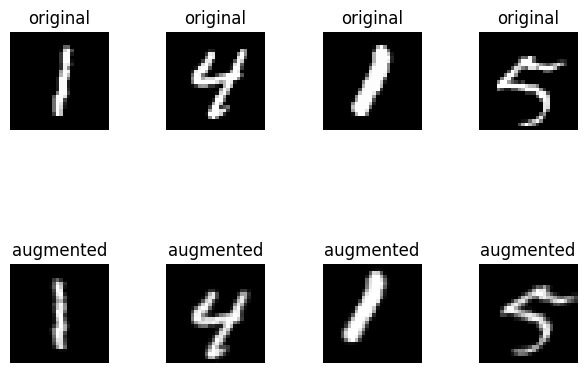

In [8]:
dataset = load_mnist()
data = dataset["data"] / 255.0
labels = dataset["target"]
show_augmented_data(data, DatasetType.MNIST, (28,28), 4)

##### USPS

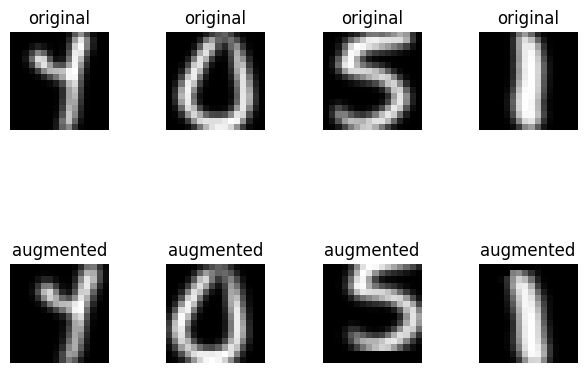

In [9]:
dataset = load_usps()
data = dataset["data"] / 255.0
labels = dataset["target"]
show_augmented_data(data, DatasetType.USPS, (16,16), 4)

##### FMNIST

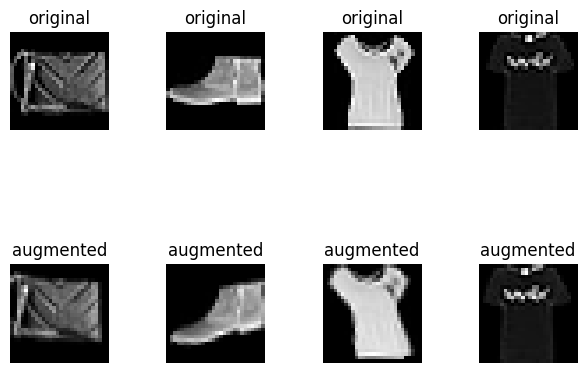

In [10]:
dataset = load_fmnist()
data = dataset["data"] / 255
labels = dataset["target"]
show_augmented_data(data, DatasetType.FASHION_MNIST, (28,28), 4)

# Evaluation

Set multiple Seeds here

In [11]:
seeds = [21, 42]

#### MNIST

In [12]:
flat_mnist_multiple_seeds_clustpy_ae, hierarchical_mnist_multiple_seeds_clustpy_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
    dataset_type=DatasetType.MNIST,
    seeds=seeds,
)

flat_mnist_multiple_seeds_stacked_ae, hierarchical_mnist_multiple_seeds_stacked_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
    dataset_type=DatasetType.MNIST,
    seeds=seeds,
)

mean_flat_mnist = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_mnist_multiple_seeds_clustpy_ae, flat_mnist_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_mnist = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [flat_mnist_multiple_seeds_clustpy_ae, flat_mnist_multiple_seeds_stacked_ae, hierarchical_mnist_multiple_seeds_clustpy_ae, hierarchical_mnist_multiple_seeds_stacked_ae], ignore_index=True
    )
)

-------------------------------------------Run: MNIST_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 0.00025156666666666664min
-------------------------------------------Run: MNIST_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.52e-05min
-------------------------------------------Run: MNIST_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 4.3100000000000004e-05min
-------------------------------------------Run: MNIST_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 4.243333333333333e-05min


#### USPS

In [13]:
flat_usps_multiple_seeds_clustpy_ae, hierarchical_usps_multiple_seeds_clustpy_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
    dataset_type=DatasetType.USPS,
    seeds=seeds,
)

flat_usps_multiple_seeds_stacked_ae, hierarchical_usps_multiple_seeds_stacked_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
    dataset_type=DatasetType.USPS,
    seeds=seeds,
)

mean_flat_usps = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_usps_multiple_seeds_clustpy_ae, flat_usps_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_usps = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat([flat_usps_multiple_seeds_clustpy_ae, flat_usps_multiple_seeds_stacked_ae, hierarchical_usps_multiple_seeds_clustpy_ae, hierarchical_usps_multiple_seeds_stacked_ae], ignore_index=True)
)

-------------------------------------------Run: USPS_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 7.228333333333333e-05min
-------------------------------------------Run: USPS_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.841666666666667e-05min
-------------------------------------------Run: USPS_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 0.034680716666666674min
-------------------------------------------Run: USPS_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 0.022330216666666666min


#### FASHION MNIST

In [14]:
flat_fashion_multiple_seeds_clustpy_ae, hierarchical_fashion_multiple_seeds_clustpy_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
        dataset_type=DatasetType.FASHION_MNIST,
        seeds=seeds,
    )
)

flat_fashion_multiple_seeds_stacked_ae, hierarchical_fashion_multiple_seeds_stacked_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
        dataset_type=DatasetType.FASHION_MNIST,
        seeds=seeds,
    )
)

mean_flat_fashion = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_fashion_multiple_seeds_clustpy_ae, flat_fashion_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_fashion = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [hierarchical_fashion_multiple_seeds_clustpy_ae, hierarchical_fashion_multiple_seeds_stacked_ae, flat_fashion_multiple_seeds_clustpy_ae, flat_fashion_multiple_seeds_stacked_ae],
        ignore_index=True,
    )
)

-------------------------------------------Run: FASHION_MNIST_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 6.583333333333334e-05min
-------------------------------------------Run: FASHION_MNIST_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.823333333333333e-05min
-------------------------------------------Run: FASHION_MNIST_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 4.794999999999999e-05min
-------------------------------------------Run: FASHION_MNIST_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 4.44e-05min


#### REUTERS

In [15]:
flat_reuters_multiple_seeds_clustpy_ae, hierarchical_reuters_multiple_seeds_clustpy_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
        dataset_type=DatasetType.REUTERS,
        seeds=seeds,
    )
)

flat_reuters_multiple_seeds_stacked_ae, hierarchical_reuters_multiple_seeds_stacked_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
        dataset_type=DatasetType.REUTERS,
        seeds=seeds,
    )
)

mean_flat_reuters = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_reuters_multiple_seeds_clustpy_ae, flat_reuters_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_reuters = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [flat_reuters_multiple_seeds_clustpy_ae, flat_reuters_multiple_seeds_stacked_ae, hierarchical_reuters_multiple_seeds_clustpy_ae, hierarchical_reuters_multiple_seeds_stacked_ae],
        ignore_index=True,
    )
)

-------------------------------------------Run: REUTERS_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 0.00010451666666666665min
-------------------------------------------Run: REUTERS_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 7.814999999999999e-05min
-------------------------------------------Run: REUTERS_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 0.1822497min
-------------------------------------------Run: REUTERS_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 0.1743674min


## Flat Clustering

In [16]:
flat_combined_df = pd.concat([mean_flat_mnist, mean_flat_usps, mean_flat_fashion, mean_flat_reuters], ignore_index=True)
# Pivot the DataFrame to match the desired format
pivot_df = flat_combined_df.pivot(index=['method', 'autoencoder'], columns='dataset', values=['nmi', 'acc', 'ari',])

# Reorder the columns to match the order in the image
pivot_df = pivot_df.reindex(columns=[('nmi', DatasetType.MNIST.value), ('acc', DatasetType.MNIST.value), ('ari', DatasetType.MNIST.value),
                                     ('nmi', DatasetType.USPS.value), ('acc', DatasetType.USPS.value), ('ari', DatasetType.USPS.value),
                                     ('nmi', DatasetType.FASHION_MNIST.value), ('acc', DatasetType.FASHION_MNIST.value), ('ari', DatasetType.FASHION_MNIST.value),
                                     ('nmi', DatasetType.REUTERS.value), ('acc', DatasetType.REUTERS.value), ('ari', DatasetType.REUTERS.value)])


# For Jupyter Notebook display with better formatting
pivot_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), 
                                       ('color', '#333'), 
                                       ('border', '1px solid #ddd')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#333')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fff'), ('color', '#333') ]}
]).set_caption("Flat Clustering results")

## Hierarchical Clustering

In [17]:
hierarchical_combined = pd.concat(
    [
        mean_hierarchical_mnist,
        mean_hierarchical_usps,
        mean_hierarchical_fashion,
        mean_hierarchical_reuters,
    ],
    ignore_index=True,
)
# Pivot the DataFrame to match the desired format
pivot_df = hierarchical_combined.pivot(
    index=["method", "autoencoder"], columns="dataset", values=["dp", "lp"]
)

# Reorder the columns to match the order in the image
pivot_df = pivot_df.reindex(columns=[('dp', DatasetType.MNIST.value), ('lp', DatasetType.MNIST.value), 
                                     ('dp', DatasetType.USPS.value), ('lp', DatasetType.USPS.value),
                                     ('dp', DatasetType.FASHION_MNIST.value), ('lp', DatasetType.FASHION_MNIST.value),
                                     ('dp', DatasetType.REUTERS.value), ('lp', DatasetType.REUTERS.value)])


# For Jupyter Notebook display with better formatting
pivot_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), 
                                       ('color', '#333'), 
                                       ('border', '1px solid #ddd')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#333')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fff'), ('color', '#333') ]}
]).set_caption("Hierarchical Clustering results")

# Visualization of DeepECT Cluster Tree

In [ ]:
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_dataset
import practical.DeepClustering.DeepECT.deepect_adjusted as deepect_paper
def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, dataset_type):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        center = torch.from_numpy(np.expand_dims(node.center, axis=0))
        
        image = autoencoder.decode(center).detach().numpy()
        
        if dataset_type == DatasetType.USPS:
            image = image.reshape(16,16)
        else:
            image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

def visualize_cluster_tree(dataset_type: DatasetType, autoencoder_type: AutoencoderType):
    dataset = get_dataset(dataset_type)

    data = dataset["data"]
    labels = dataset["target"]

    autoencoder = pretraining(autoencoder_type, None, dataset, 42, 10)

    deepect = deepect_paper.DeepECT(
        autoencoder=autoencoder,
        clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
        max_leaf_nodes=20,
        random_state=np.random.RandomState(42),
    )

    deepect.fit(data)

    print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

    build_and_visualize_tree(deepect.tree_.root, autoencoder, dataset_type)

cpu


Fit:   1%|          | 503/50000 [00:35<10:55:26,  1.26it/s]

Leaf assignments: 48732
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:18<11:34:03,  1.18it/s]

Leaf assignments: 30922
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:53<8:02:20,  1.68it/s] 

Leaf assignments: 20642
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2001/50000 [02:30<13:41:09,  1.03s/it]

Leaf assignments: 15744
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2503/50000 [03:09<8:05:38,  1.63it/s] 

Leaf assignments: 18325
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3003/50000 [03:45<7:48:57,  1.67it/s] 

Leaf assignments: 12913
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [04:22<8:05:38,  1.60it/s] 

Leaf assignments: 9879
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [04:59<7:56:07,  1.61it/s] 

Leaf assignments: 12646
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4502/50000 [05:41<14:23:08,  1.14s/it]

Leaf assignments: 5861
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5001/50000 [06:27<13:58:02,  1.12s/it]

Leaf assignments: 6452
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5501/50000 [07:14<14:01:26,  1.13s/it]

Leaf assignments: 7400
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6001/50000 [08:02<16:06:46,  1.32s/it]

Leaf assignments: 7024
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6502/50000 [08:51<13:26:08,  1.11s/it]

Leaf assignments: 6431
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [09:38<13:47:11,  1.15s/it]

Leaf assignments: 6723
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7501/50000 [10:25<13:12:17,  1.12s/it]

Leaf assignments: 5638
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8002/50000 [11:13<13:09:13,  1.13s/it]

Leaf assignments: 5091
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8501/50000 [12:00<12:56:47,  1.12s/it]

Leaf assignments: 6616
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [12:45<9:55:29,  1.15it/s] 

Leaf assignments: 9065
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 97.10it/s]


Accuracy:  0.8468571428571429


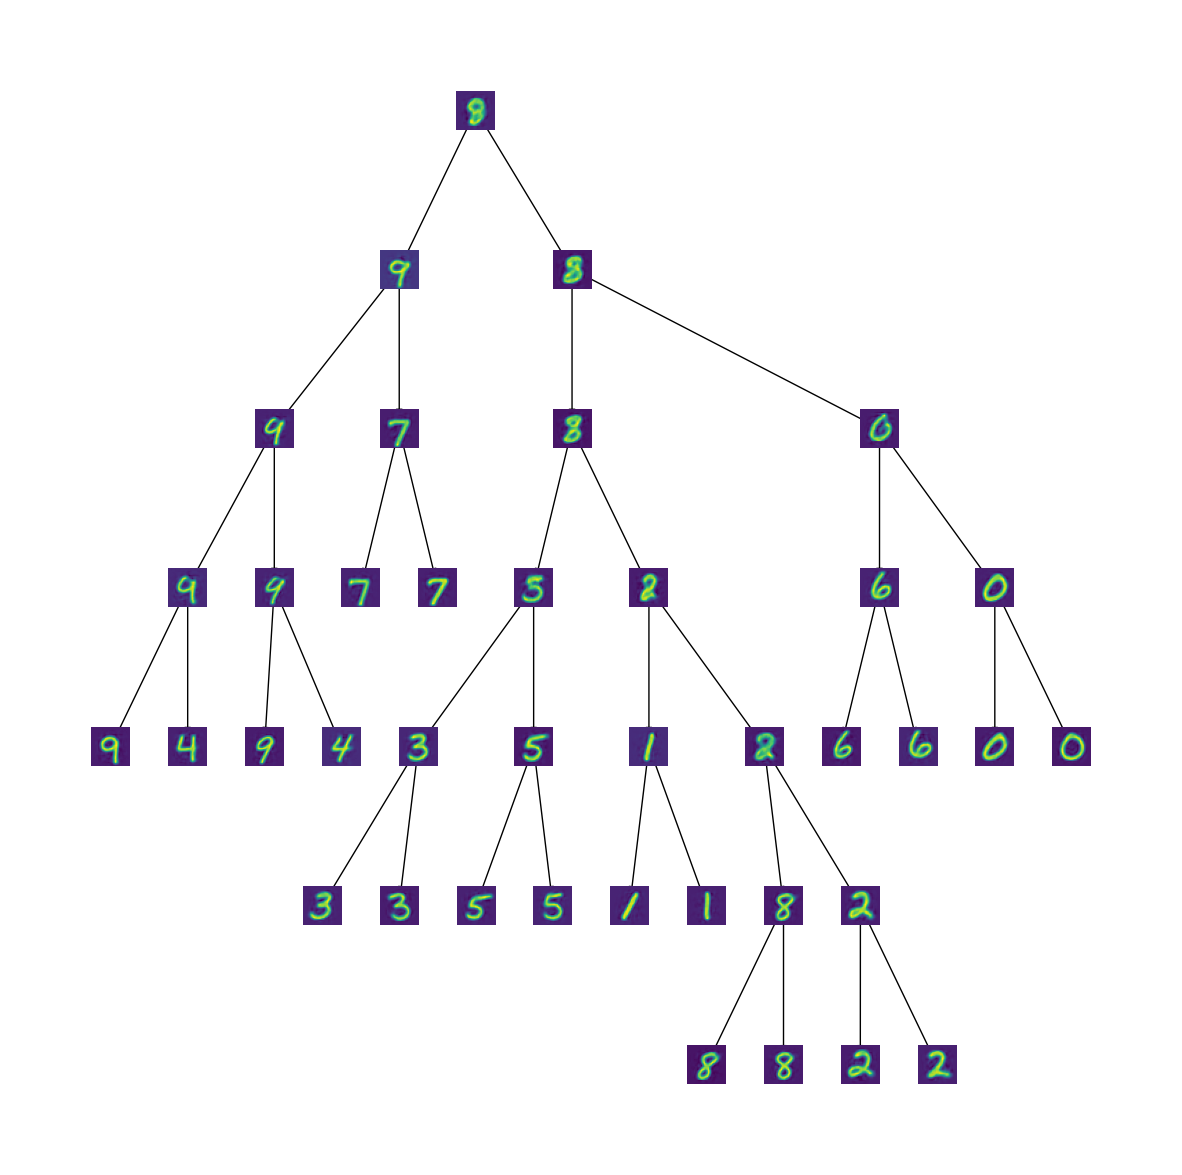

In [ ]:
visualize_cluster_tree(
    DatasetType.MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.MNIST, AutoencoderType.DEEPECT_STACKED_AE)

cpu


Fit:   1%|          | 503/50000 [00:37<8:45:16,  1.57it/s] 

Leaf assignments: 46556
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:11<10:59:45,  1.24it/s]

Leaf assignments: 22235
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:45<7:51:44,  1.71it/s] 

Leaf assignments: 22339
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2002/50000 [02:18<10:41:53,  1.25it/s]

Leaf assignments: 24994
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2502/50000 [02:52<10:12:04,  1.29it/s]

Leaf assignments: 16038
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [03:25<10:36:04,  1.23it/s]

Leaf assignments: 5087
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:58<7:26:24,  1.74it/s] 

Leaf assignments: 17650
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4002/50000 [04:30<8:45:13,  1.46it/s]

Leaf assignments: 6445
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [05:03<7:17:10,  1.73it/s] 

Leaf assignments: 9463
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [05:36<9:57:23,  1.26it/s]

Leaf assignments: 6257
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [06:14<7:53:33,  1.57it/s] 

Leaf assignments: 15138
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6002/50000 [06:47<9:29:19,  1.29it/s]

Leaf assignments: 8488
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [07:20<6:49:14,  1.77it/s]

Leaf assignments: 2859
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [13:30<612:26:29, 51.28s/it]

Leaf assignments: 6366
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [14:18<9:37:44,  1.23it/s]  

Leaf assignments: 2711
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [14:53<6:33:03,  1.78it/s]

Leaf assignments: 5536
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [15:29<6:43:01,  1.72it/s]

Leaf assignments: 2567
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9003/50000 [16:02<6:31:27,  1.75it/s]

Leaf assignments: 2414
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 114.17it/s]


Accuracy:  0.5767428571428571


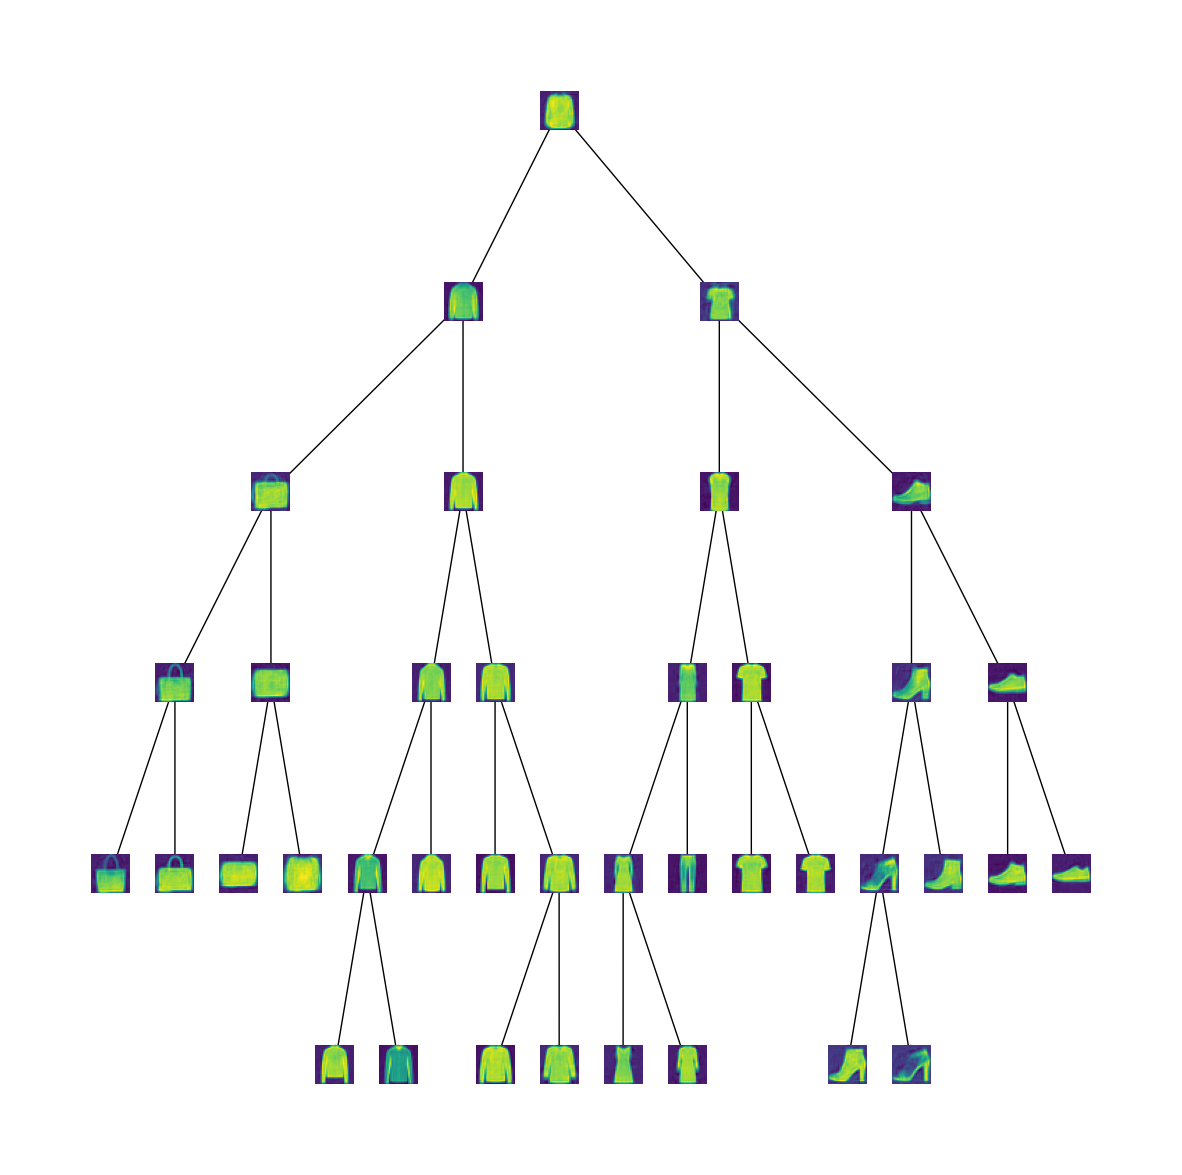

In [ ]:
visualize_cluster_tree(
    DatasetType.FASHION_MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.FASHION_MNIST, AutoencoderType.DEEPECT_STACKED_AE)

cpu


Fit:   1%|          | 504/50000 [00:27<1:21:10, 10.16it/s]

Leaf assignments: 3673
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1003/50000 [00:52<1:20:40, 10.12it/s]

Leaf assignments: 5678
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:17<1:18:44, 10.26it/s]

Leaf assignments: 4542
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2003/50000 [01:43<1:27:22,  9.16it/s]

Leaf assignments: 2270
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2504/50000 [02:08<1:18:44, 10.05it/s]

Leaf assignments: 1531
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [02:35<1:30:42,  8.64it/s]

Leaf assignments: 2101
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:03<1:34:40,  8.19it/s]

Leaf assignments: 785
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [03:31<1:31:32,  8.37it/s]

Leaf assignments: 1037
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [03:59<1:25:33,  8.86it/s]

Leaf assignments: 1349
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [04:27<2:04:26,  6.03it/s]

Leaf assignments: 671
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [04:56<1:34:26,  7.85it/s]

Leaf assignments: 967
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6003/50000 [05:27<1:37:35,  7.51it/s]

Leaf assignments: 866
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [05:57<1:28:44,  8.17it/s]

Leaf assignments: 1173
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7003/50000 [06:25<1:26:38,  8.27it/s]

Leaf assignments: 657
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [06:54<1:47:55,  6.56it/s]

Leaf assignments: 405
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [07:24<1:38:16,  7.12it/s]

Leaf assignments: 388
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [07:53<1:27:17,  7.92it/s]

Leaf assignments: 457
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [08:22<1:43:20,  6.61it/s]

Leaf assignments: 729
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 37/37 [00:00<00:00, 110.28it/s]


Accuracy:  0.6300279630027963


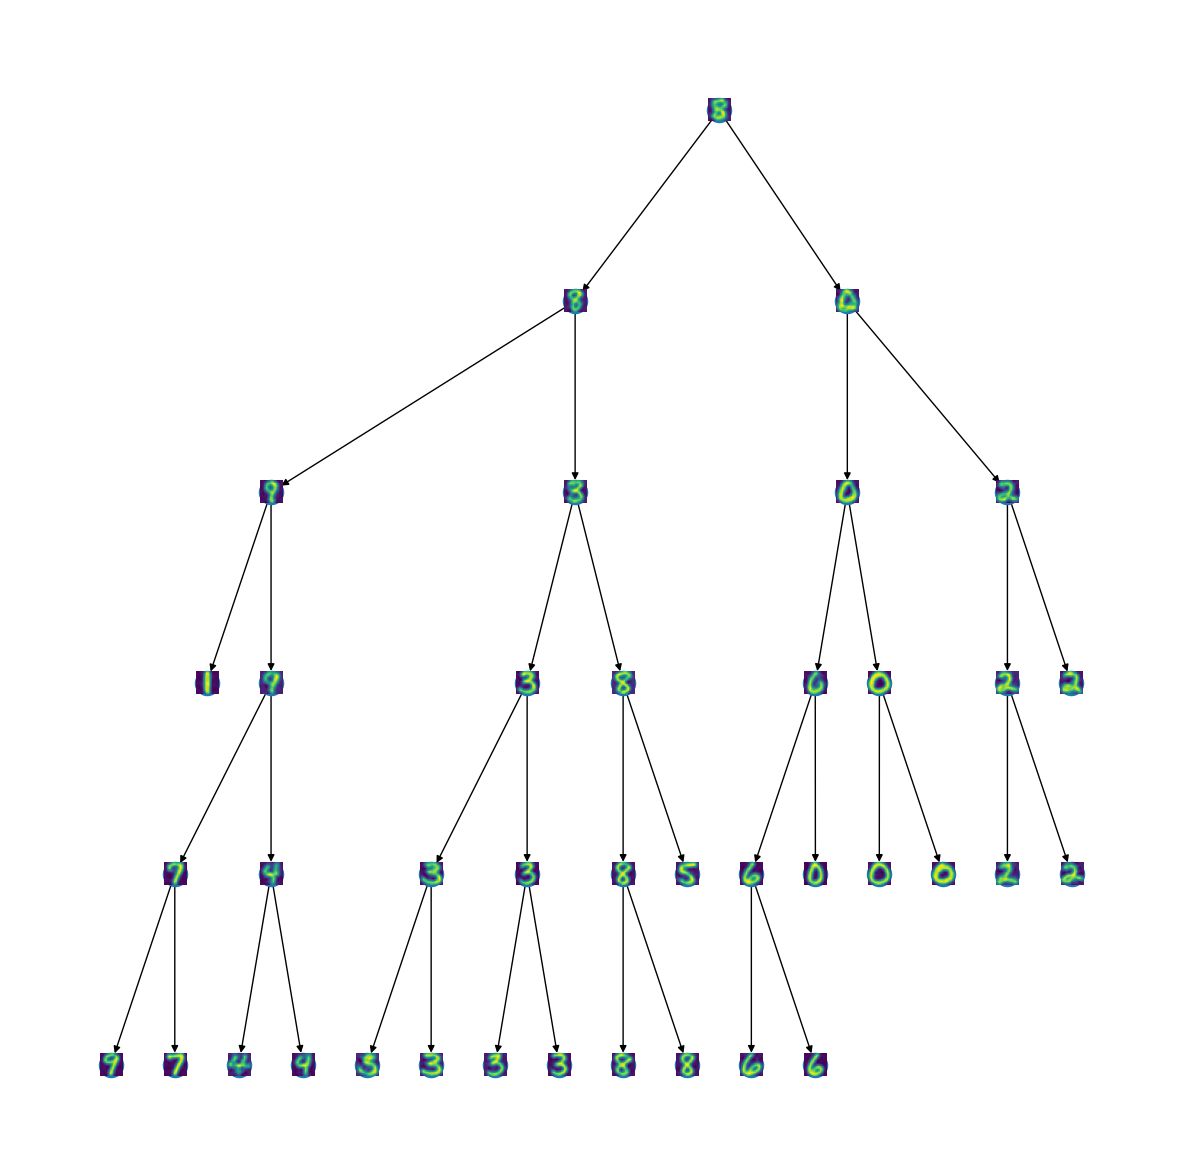

In [ ]:
visualize_cluster_tree(
    DatasetType.USPS, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.USPS, AutoencoderType.DEEPECT_STACKED_AE)